In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
import cv2
import numpy as np
from skimage import data, color, feature
import matplotlib.pyplot as plt
from skimage import transform
import tensorflow as tf

In [6]:
def make_data_from_folder(path):
  data = []
  for img in os.listdir(path):
      pic = cv2.imread(os.path.join(path,img))
      pic = cv2.cvtColor(pic,cv2.COLOR_BGR2RGB)
      # pic = cv2.resize(pic,(80,80))
      data.append(pic)
  return data

In [7]:
def plot_images(images):
  fig, ax = plt.subplots(3, 5, figsize=(32, 16))
  for i, axi in enumerate(ax.flat):
      axi.imshow(images[i], cmap='gray')
      axi.axis('off')

In [8]:
def apply_gray(images):
  return [color.rgb2gray(img) for img in images]

In [9]:
def apply_gaussian(images):
    blured_images = [cv2.GaussianBlur(img, (15, 15), 0) for img in images]
    return blured_images

# Automatic brightness and contrast optimization with optional histogram clipping
def automatic_brightness_and_contrast(image, clip_hist_percent):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Calculate grayscale histogram
    hist = cv2.calcHist([gray],[0],None,[256],[0,256])
    hist_size = len(hist)
    
    # Calculate cumulative distribution from the histogram
    accumulator = []
    accumulator.append(float(hist[0]))
    for index in range(1, hist_size):
        accumulator.append(accumulator[index -1] + float(hist[index]))
    
    # Locate points to clip
    maximum = accumulator[-1]
    clip_hist_percent *= (maximum/100.0)
    clip_hist_percent /= 2.0
    
    # Locate left cut
    minimum_gray = 0
    while accumulator[minimum_gray] < clip_hist_percent:
        minimum_gray += 1
    
    # Locate right cut
    maximum_gray = hist_size -1
    while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
        maximum_gray -= 1
    
    # Calculate alpha and beta values
    alpha = 255 / (maximum_gray - minimum_gray)
    beta = -minimum_gray * alpha
    

    auto_result = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return (auto_result, alpha, beta)

In [10]:
def apply_auto_brightness_and_contrast(images, param):
  new_images = [automatic_brightness_and_contrast(img, param)[0] for img in images]
  return new_images

In [11]:
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

Adatok beolvasása:

In [12]:
correct_data = make_data_from_folder('/content/drive/MyDrive/new2.0/correct')
incorrect_data_1 = make_data_from_folder('/content/drive/MyDrive/new2.0/incorrect_1')
incorrect_data_2 = make_data_from_folder('/content/drive/MyDrive/new2.0/incorrect_2')
incorrect_data_3 = make_data_from_folder('/content/drive/MyDrive/new2.0/incorrect_3')

pozitív tanító adatok:

In [13]:
positive_patches = apply_auto_brightness_and_contrast(correct_data, 10)
positive_patches = apply_gray(positive_patches)
positive_patches = np.stack(positive_patches, axis=0)
positive_patches.shape

(120, 300, 300)

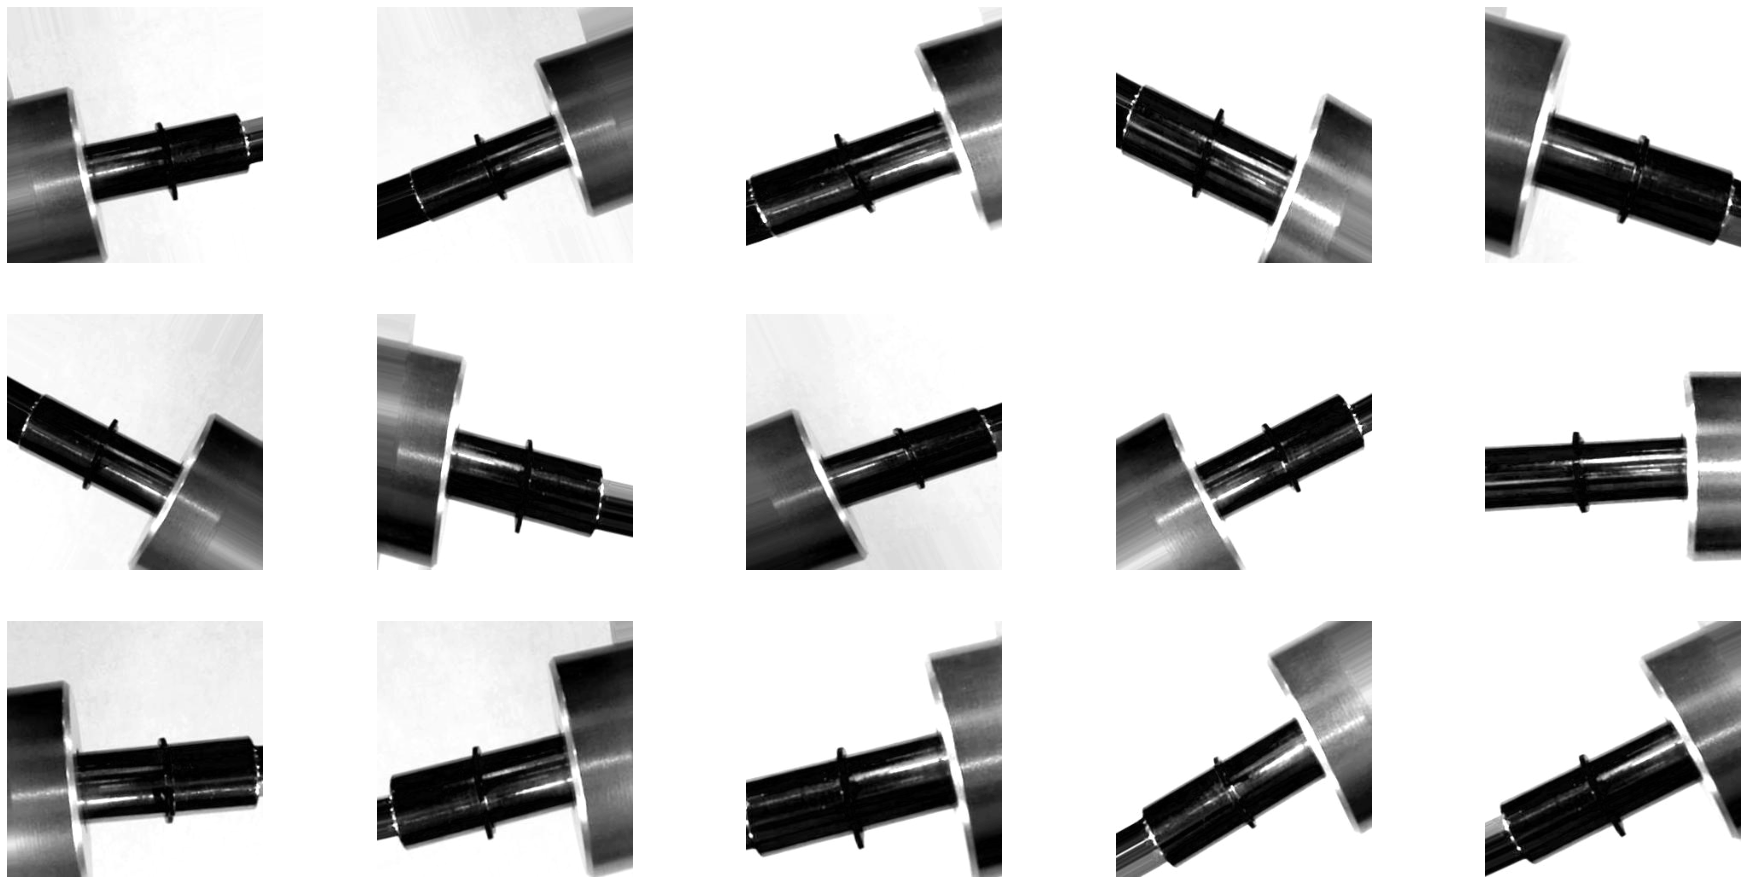

In [14]:
plot_images(positive_patches)

Negatív tanító adatok (magasabb):

In [15]:
negative_1_patches = apply_auto_brightness_and_contrast(incorrect_data_1, 10)
negative_1_patches = apply_gray(negative_1_patches)
negative_1_patches = np.stack(negative_1_patches, axis=0)
negative_1_patches.shape

(119, 300, 300)

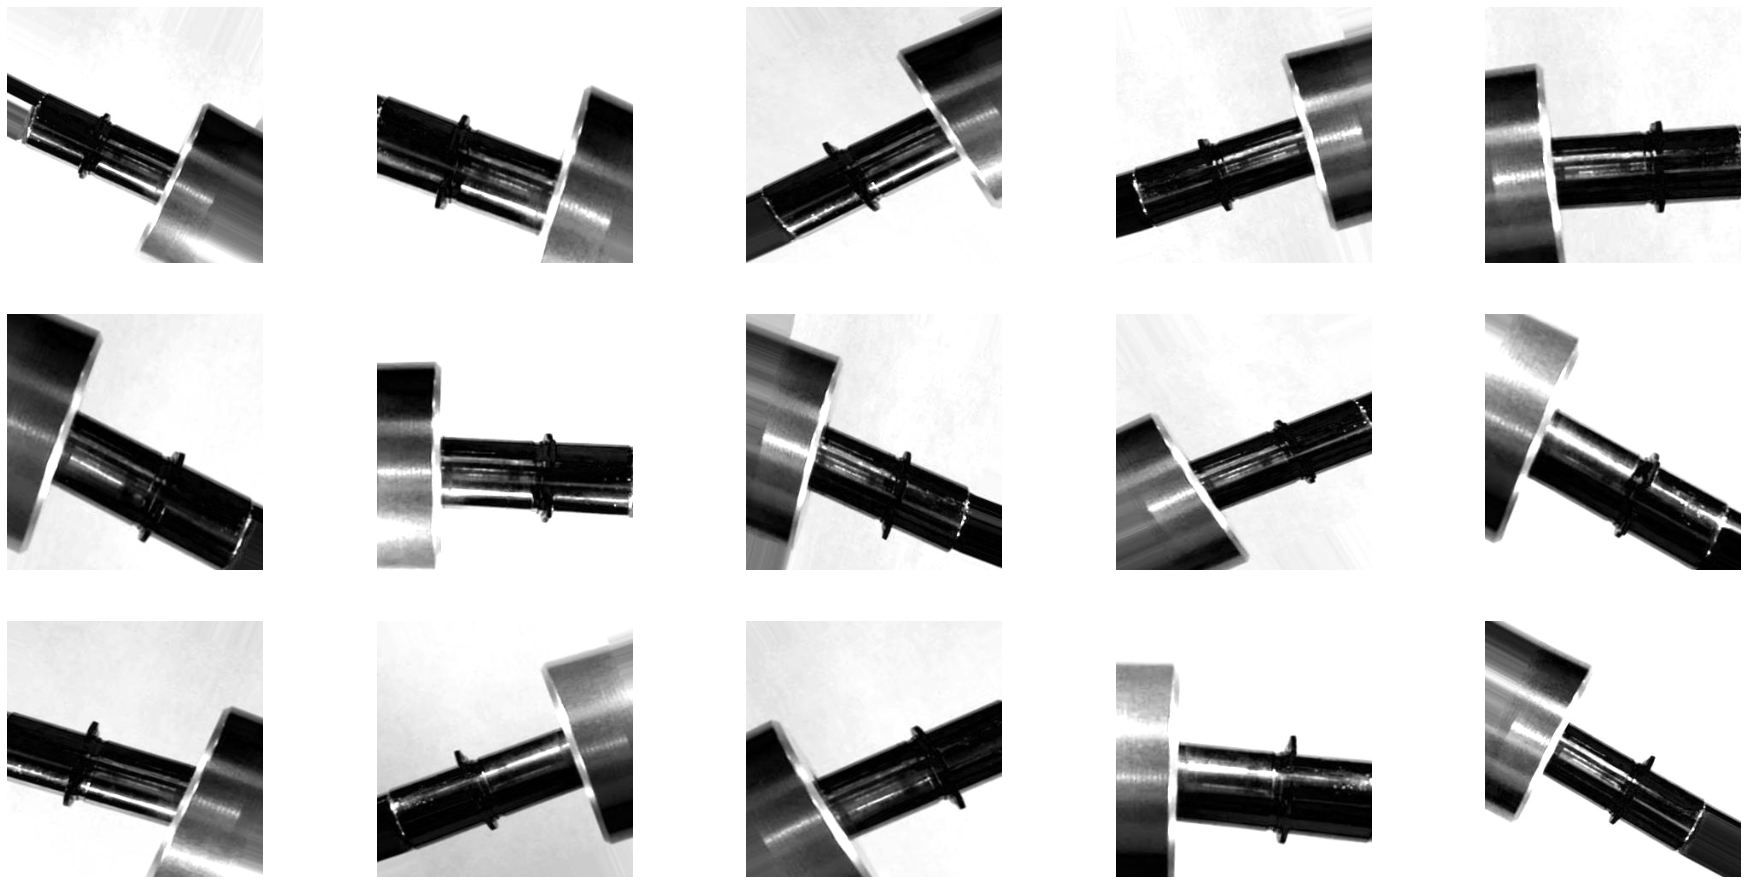

In [16]:
plot_images(negative_1_patches)

Negatív tanító adatok (ferde):

In [17]:
negative_2_patches = apply_auto_brightness_and_contrast(incorrect_data_2, 10)
negative_2_patches = apply_gray(negative_2_patches)
negative_2_patches = np.stack(negative_2_patches, axis=0)
negative_2_patches.shape

(119, 300, 300)

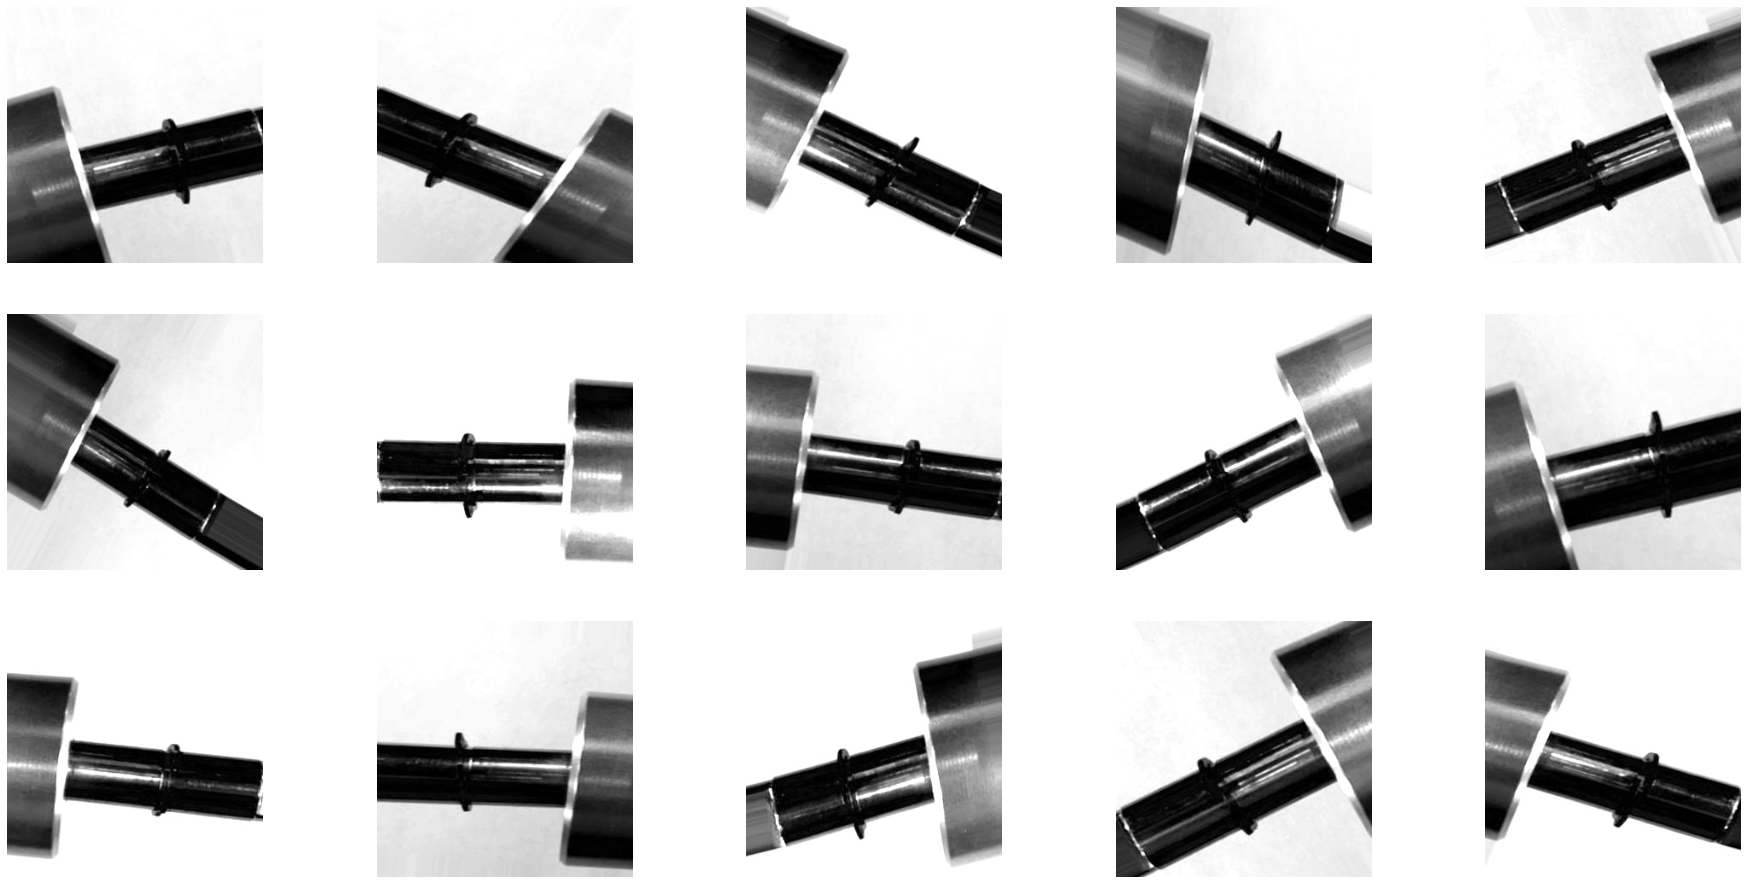

In [18]:
plot_images(negative_2_patches)

In [19]:
negative_3_patches = apply_auto_brightness_and_contrast(incorrect_data_3, 10)
negative_3_patches = apply_gray(negative_3_patches)
negative_3_patches = np.stack(negative_3_patches, axis=0)
negative_3_patches.shape

(118, 300, 300)

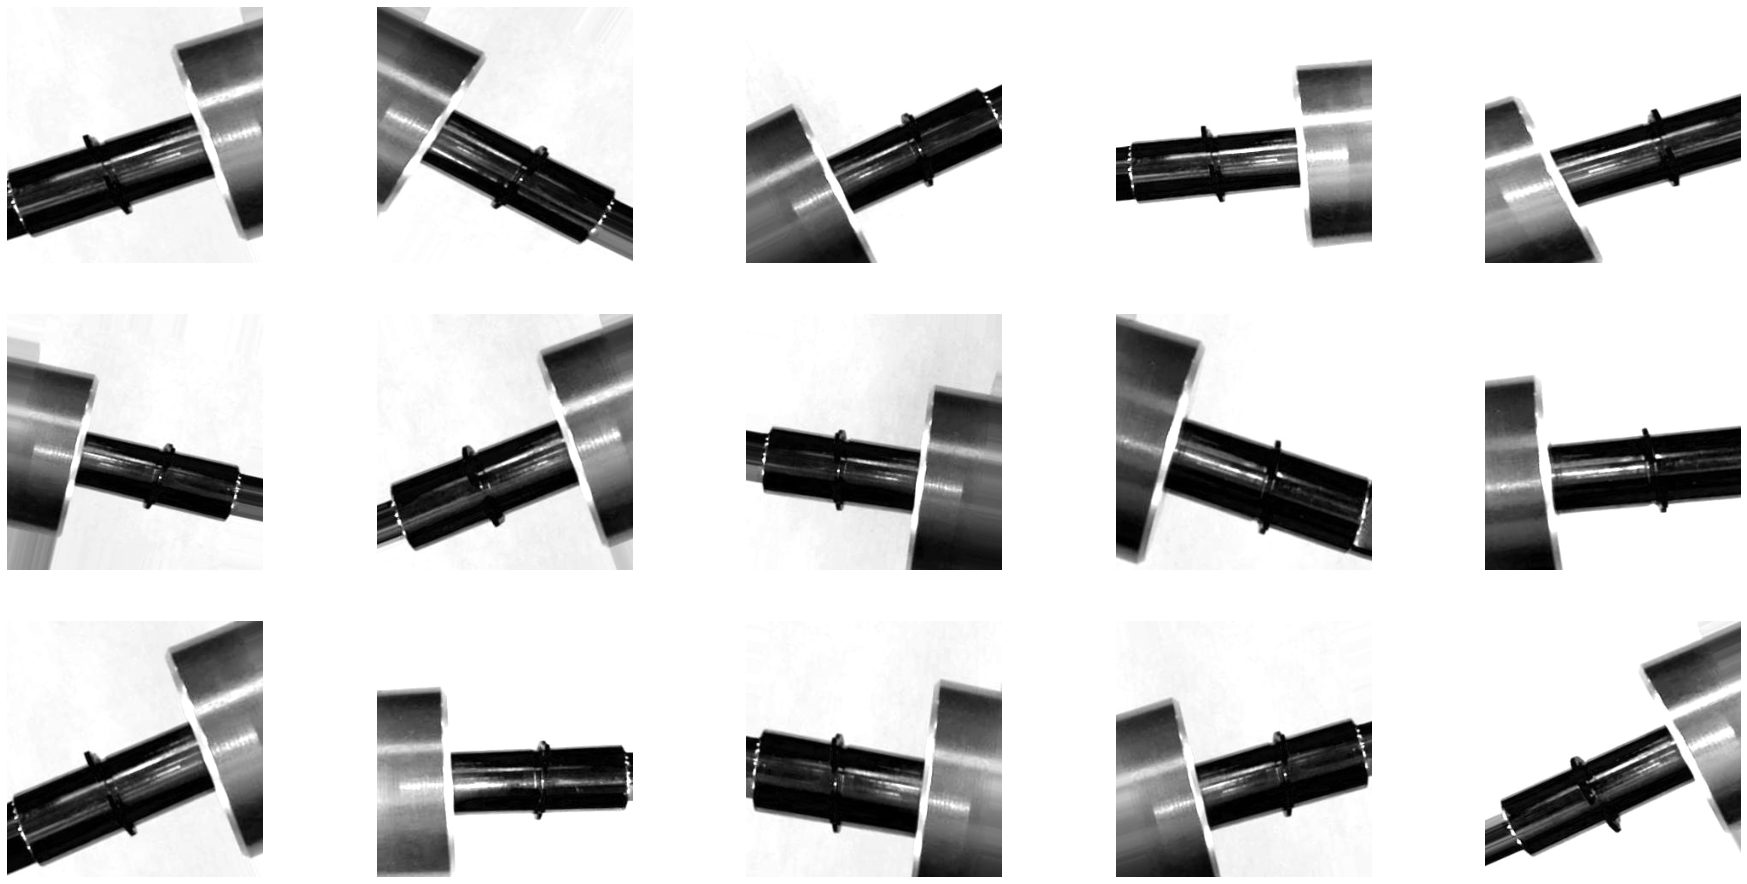

In [20]:
plot_images(negative_3_patches)

Címkék elkszítése:

In [21]:
from itertools import chain
X = np.array([feature.hog(im)
                    for im in chain(positive_patches,
                                    negative_1_patches,
                                    negative_2_patches,
                                    negative_3_patches)])
#pozitívak címkéi nullák
y = np.zeros(X.shape[0])
y[: positive_patches.shape[0]] = 0

#első negatív halmaz címkéi egyesek
border_1 = positive_patches.shape[0] + negative_1_patches.shape[0]
y[positive_patches.shape[0] : border_1] = 1

#második negatív halmaz címkéi kettesek
border_2 = border_1 + negative_2_patches.shape[0]
y[border_1 : border_2] = 2

#harmadiké hármasok
y[border_2 :] = 3

In [22]:
X.shape

(476, 99225)

In [23]:
y

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

names = [
    "Nearest Neighbors",
    "SVM",
    #"RBF SVM",
    #"Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes"
    #"QDA",
]

classifiers = [
    KNeighborsClassifier(),
    SVC(),
    #SVC(gamma=2, C=1),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB()
    #QuadraticDiscriminantAnalysis(),
]

In [25]:
from sklearn.model_selection import cross_val_score

for i, cf in enumerate(classifiers):  
  print(f"{names[i]}: {cross_val_score(cf, X, y)}")

Nearest Neighbors: [0.30208333 0.30526316 0.25263158 0.32631579 0.31578947]
SVM: [0.27083333 0.38947368 0.27368421 0.37894737 0.35789474]
Decision Tree: [0.46875    0.37894737 0.53684211 0.50526316 0.4       ]
Random Forest: [0.3125     0.21052632 0.28421053 0.27368421 0.24210526]
Neural Net: [0.28125    0.29473684 0.36842105 0.34736842 0.44210526]
AdaBoost: [0.35416667 0.38947368 0.41052632 0.45263158 0.49473684]
Naive Bayes: [0.32291667 0.48421053 0.33684211 0.47368421 0.31578947]


<h1>A knn osztályozóval megyünk tovább:<h1>

In [26]:
from sklearn.metrics import accuracy_score
def param_finder_knn(neighbors, X, y, algos):
  scores = [] 
  max_score = 0
  max_n = 0
  max_algo = ""

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

  if type(neighbors) != int:
    for n in neighbors:
      model = KNeighborsClassifier(n_neighbors=n, algorithm=algos)
      model.fit(X_train,y_train)
      y_pred = model.predict(X_test)
      new_score = accuracy_score( y_test, y_pred)
      scores.append(new_score)
      if new_score > max_score:
        max_n = n
        max_score = new_score

    return scores, max_n
  else:
    for a in algos:
      model = KNeighborsClassifier(n_neighbors=neighbors, algorithm=a)
      model.fit(X_train,y_train)
      y_pred = model.predict(X_test)
      new_score = accuracy_score( y_test, y_pred)
      scores.append(new_score)
      if new_score > max_score:
        max_algo = a
        max_score = new_score

    return scores, max_algo
  

In [27]:
neighbors = [1,2,3,4,5,6,7,8,9,10]
scores, max_n = param_finder_knn(neighbors, X, y, "auto")
max_n

3

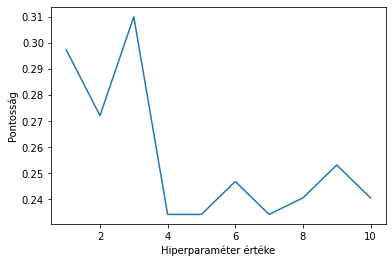

In [28]:
plt.plot(neighbors, scores)
plt.xlabel("Hiperparaméter értéke")
plt.ylabel("Pontosság")
plt.show()

Mivel azt kaptuk eredményül hogy az 1 az optimális hiperparaméter, így próbáljuk ki ezzel a paraméterrel a cross validációt.

In [29]:
new_model = KNeighborsClassifier(max_n)
cross_val_score(new_model, X, y)

array([0.29166667, 0.29473684, 0.28421053, 0.32631579, 0.28421053])

Most az algoritmus típusát is próbáljuk végig:

In [30]:
algos = ["auto", "ball_tree", "kd_tree", "brute"]

scores, max_algo = param_finder_knn(max_n, X, y, algos)
max_algo

'auto'

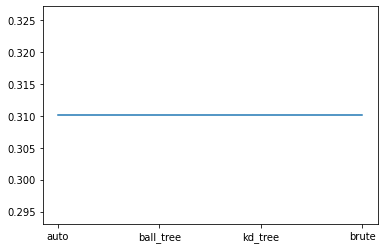

In [31]:
plt.plot(algos, scores)

In [32]:
scores

[0.310126582278481, 0.310126582278481, 0.310126582278481, 0.310126582278481]

Mivel az "auto" jött ki végeredménynek, így ezt nem kell újra próbálni, hiszen ez az alapértelmezett.

Nézzük meg a predikció igazságmátrixát:

[[29 10  9  4]
 [11  9  8  2]
 [11 12  6  5]
 [ 7 14 16  5]]


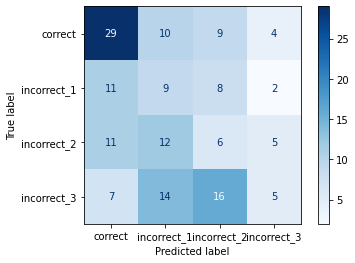

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = KNeighborsClassifier(n_neighbors=max_n, algorithm=max_algo)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        display_labels=["correct", "incorrect_1", "incorrect_2", "incorrect_3"],
        cmap=plt.cm.Blues
    )

print(disp.confusion_matrix)

# plt.imshow(confusion_matrix(y_test, y_pred))

Modell validálása:

In [34]:
from sklearn.model_selection import validation_curve
train_score, val_score = validation_curve(KNeighborsClassifier(), X, y, 
                                          param_name='n_neighbors', param_range=neighbors, cv=5)

Text(0.5, 1.0, 'plm seeger knn model validáció')

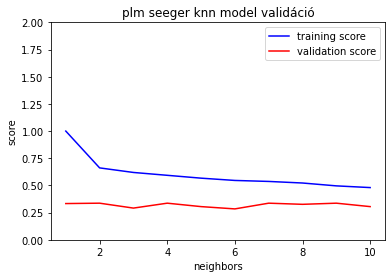

In [35]:
plt.plot(neighbors, np.median(train_score, 1), color='blue', label='training score')
plt.plot(neighbors, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 2)
plt.xlabel('neighbors')
plt.ylabel('score');
plt.title('plm seeger knn model validáció')

Teszteljük le néhány képpel:

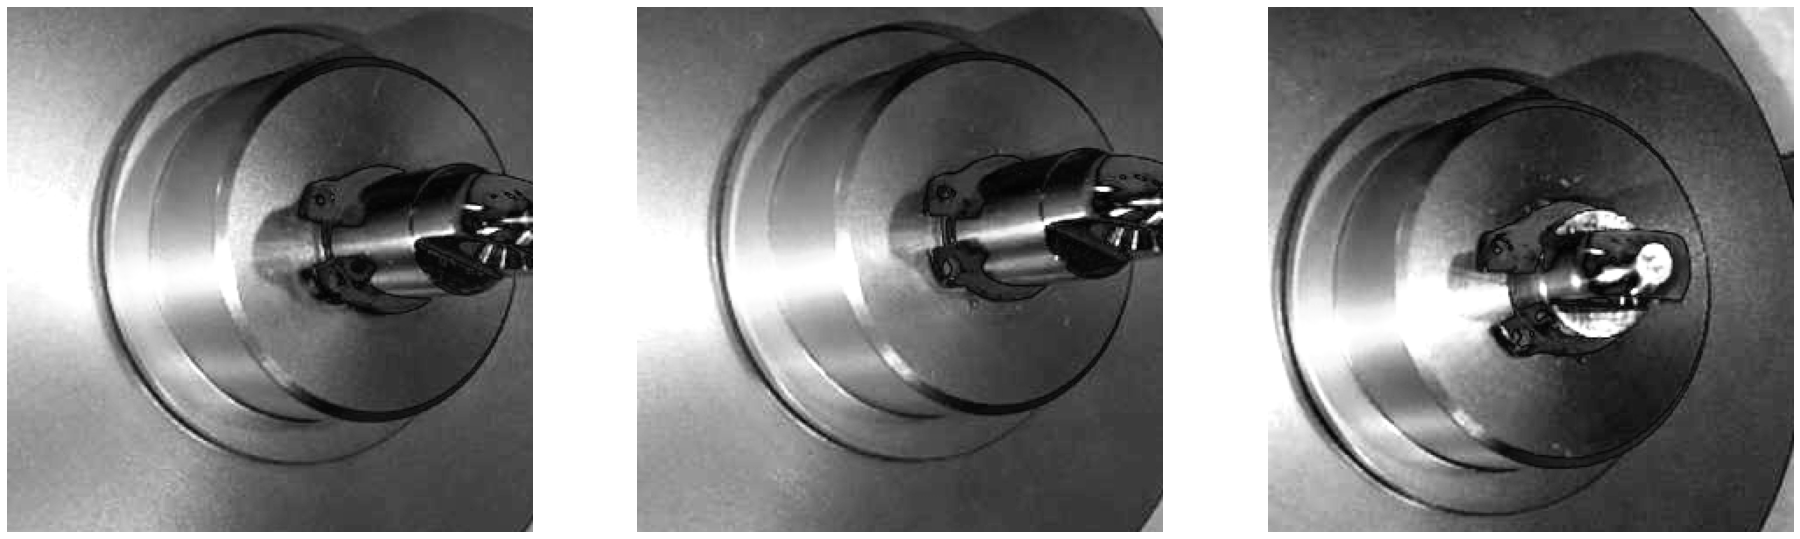

In [36]:
test_images = make_data_from_folder('/content/drive/MyDrive/focus_train/crop_test')
test_images = apply_auto_brightness_and_contrast(test_images, 10)
test_images = apply_gray(test_images)

fig, ax = plt.subplots(1, 3, figsize=(32, 16))
for i, axi in enumerate(ax.flat):
    axi.imshow(test_images[i], cmap='gray')
    axi.axis('off')

In [37]:
model.score(X_test, y_test)

0.310126582278481

In [38]:
test_hog = np.array([feature.hog(im) for im in test_images])

In [39]:
model.predict(test_hog)

array([3., 0., 2.])

most augmentáltakkal:

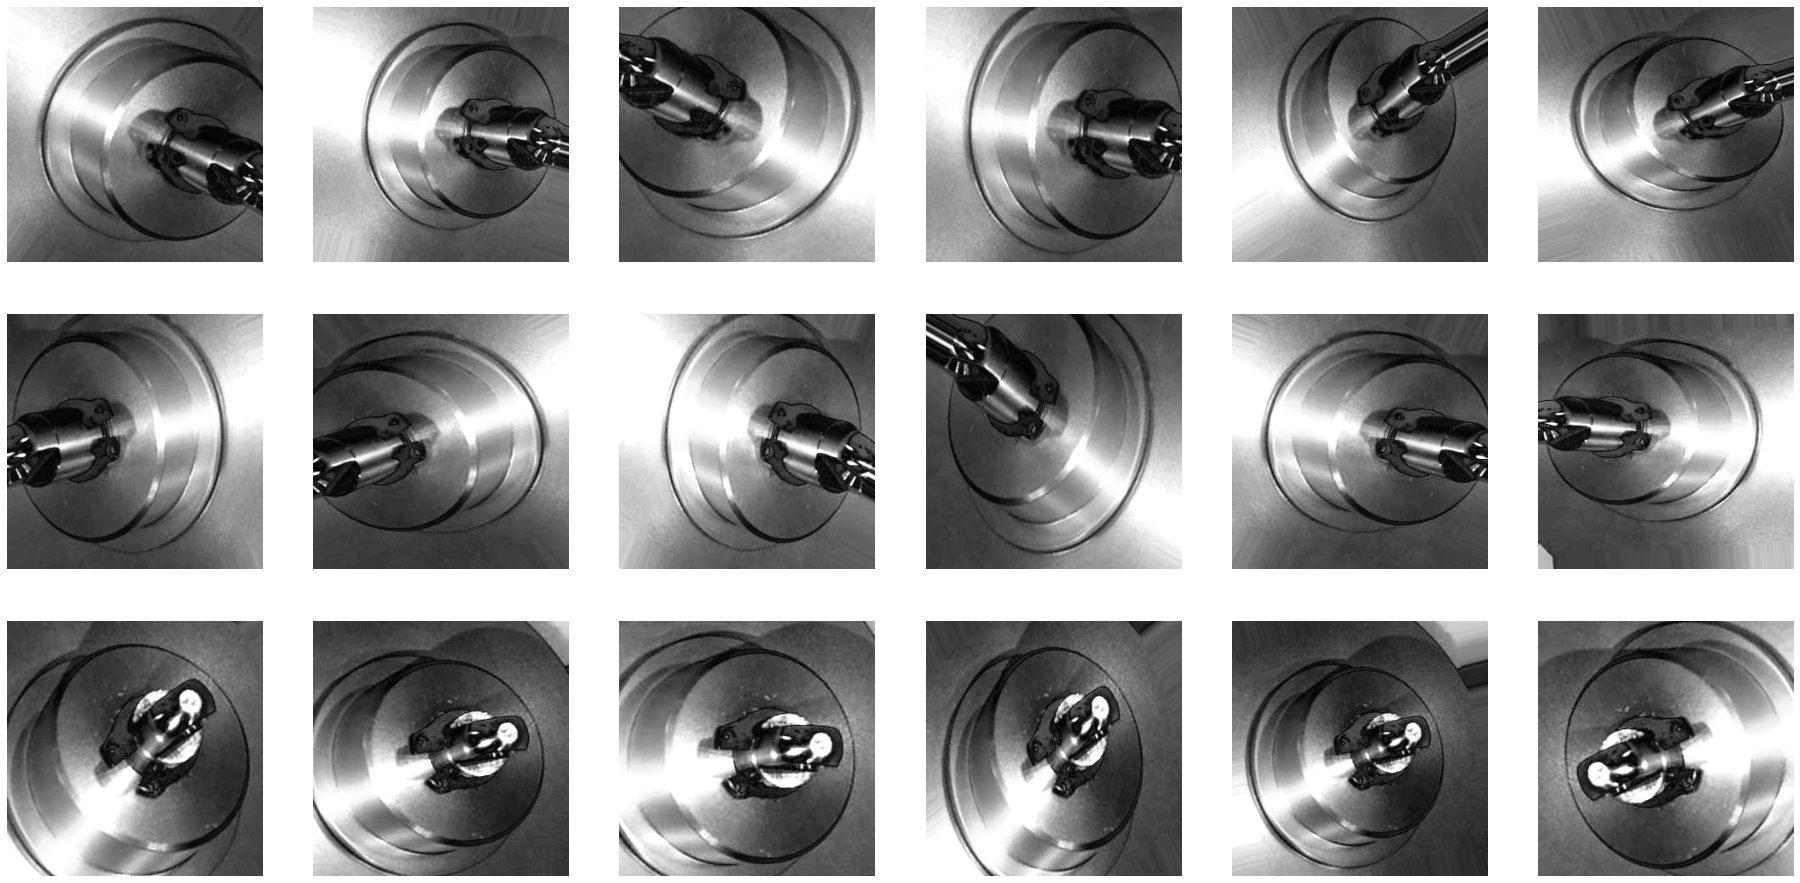

In [40]:
test_images = make_data_from_folder('/content/drive/MyDrive/focus_train/crop&aug_test')
test_images = apply_auto_brightness_and_contrast(test_images, 10)
test_images = apply_gray(test_images)

fig, ax = plt.subplots(3, 6, figsize=(32, 16))
for i, axi in enumerate(ax.flat):
    axi.imshow(test_images[i], cmap='gray')
    axi.axis('off')

In [41]:
test_hog = np.array([feature.hog(im) for im in test_images])

modell kiválasztása:

In [42]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# model = KNeighborsClassifier(n_neighbors=max_n, algorithm=max_algo)
# model.fit(X_train,y_train)
# y_pred = model.predict(X_test)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = SVC()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

In [43]:
model.predict(test_hog)

array([1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.])

helyes osztályok:

In [44]:
classes = [0, 1, 0, 0, 3, 3, 3, 0, 1, 1, 1, 3, 1, 0, 3, 0, 1, 3]

In [45]:
model.score(test_hog, classes)

0.3333333333333333

csak correct képek:

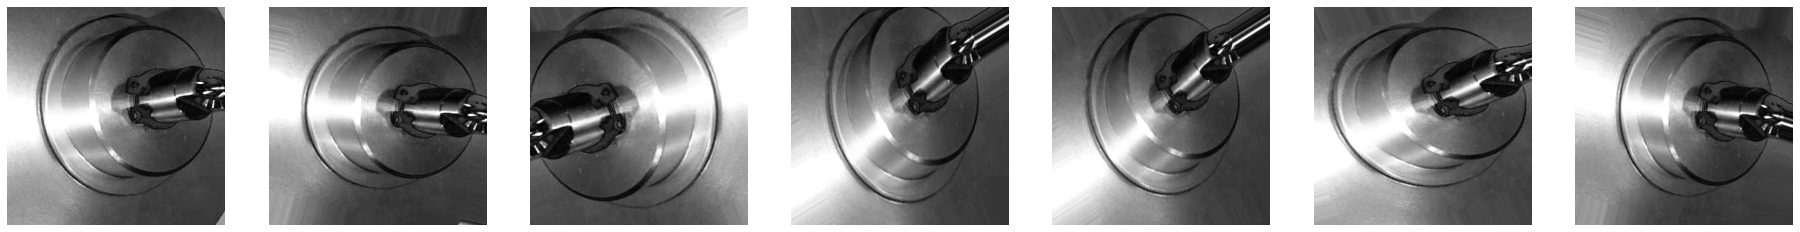

In [46]:
test_images = make_data_from_folder('/content/drive/MyDrive/focus_train/test_correct')
test_images = apply_auto_brightness_and_contrast(test_images, 10)
test_images = apply_gray(test_images)

fig, ax = plt.subplots(1, 7, figsize=(32, 16))
for i, axi in enumerate(ax.flat):
    axi.imshow(test_images[i], cmap='gray')
    axi.axis('off')

In [47]:
test_correct_hog = np.array([feature.hog(im) for im in test_images])

In [48]:
model.predict(test_correct_hog)

array([1., 1., 1., 1., 1., 1., 1.])

csak correct_1 képek

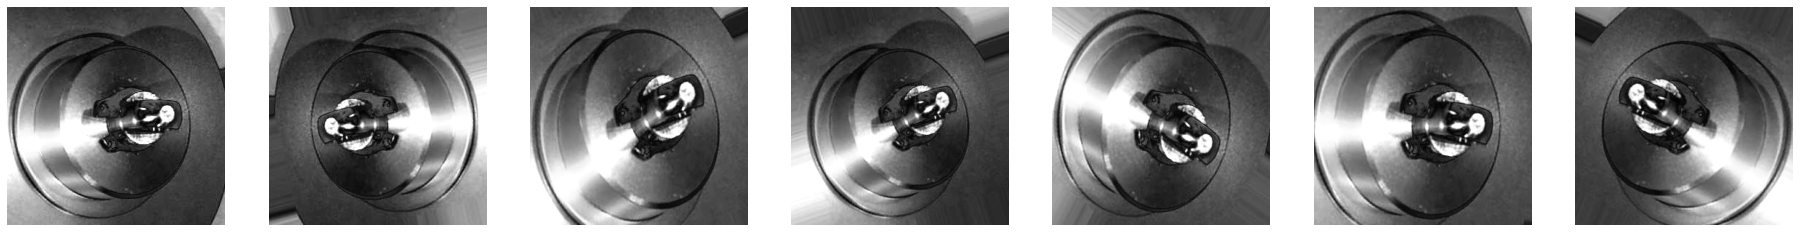

In [49]:
test_images_1 = make_data_from_folder('/content/drive/MyDrive/focus_train/test_incorrect_1')
test_images_1 = apply_auto_brightness_and_contrast(test_images_1, 10)
test_images_1 = apply_gray(test_images_1)

fig, ax = plt.subplots(1, 7, figsize=(32, 16))
for i, axi in enumerate(ax.flat):
    axi.imshow(test_images_1[i], cmap='gray')
    axi.axis('off')

In [50]:
test_incorrect_1_hog = np.array([feature.hog(im) for im in test_images_1])

In [51]:
model.predict(test_incorrect_1_hog)

array([1., 1., 1., 1., 1., 1., 1.])

incorrect_2 képek

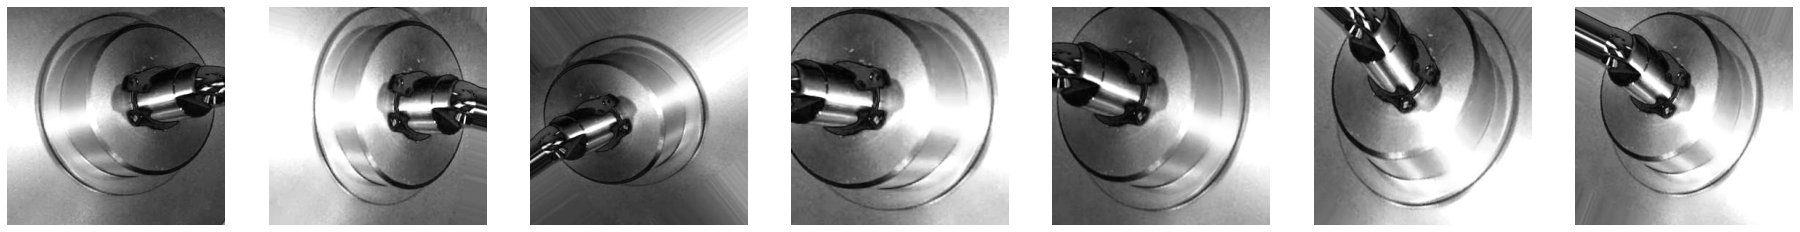

In [52]:
test_images_2 = make_data_from_folder('/content/drive/MyDrive/focus_train/test_incorrect_2')
test_images_2 = apply_auto_brightness_and_contrast(test_images_2, 10)
test_images_2 = apply_gray(test_images_2)

fig, ax = plt.subplots(1, 7, figsize=(32, 16))
for i, axi in enumerate(ax.flat):
    axi.imshow(test_images_2[i], cmap='gray')
    axi.axis('off')

In [53]:
test_incorrect_2_hog = np.array([feature.hog(im) for im in test_images_2])

In [54]:
model.predict(test_incorrect_2_hog)

array([1., 1., 1., 1., 1., 1., 1.])

csak incorrect_3 képek

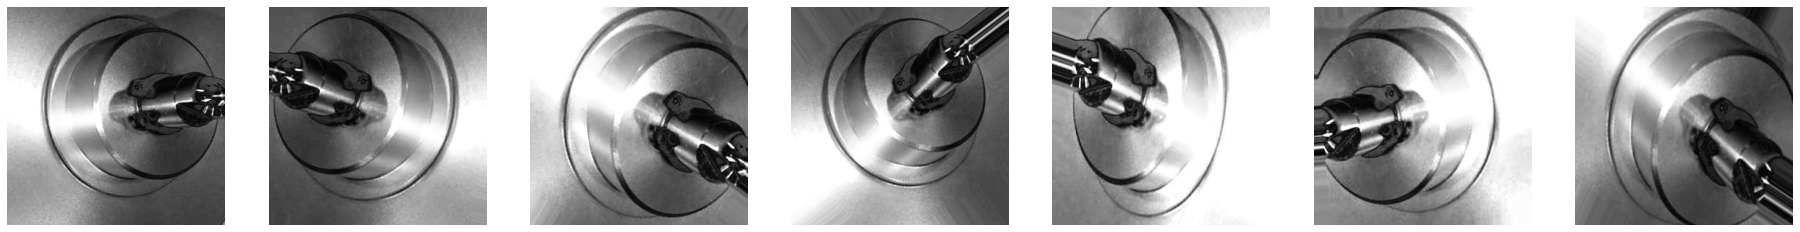

In [55]:
test_images_3 = make_data_from_folder('/content/drive/MyDrive/focus_train/test_incorrect_3')
test_images_3 = apply_auto_brightness_and_contrast(test_images_3, 10)
test_images_3 = apply_gray(test_images_3)

fig, ax = plt.subplots(1, 7, figsize=(32, 16))
for i, axi in enumerate(ax.flat):
    axi.imshow(test_images_3[i], cmap='gray')
    axi.axis('off')

In [56]:
test_incorrect_3_hog = np.array([feature.hog(im) for im in test_images_3])

In [57]:
model.predict(test_incorrect_3_hog)

array([1., 1., 1., 1., 1., 1., 1.])